In [2]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [18]:
# Import standard dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [19]:
# Import tensorflow dependencies - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [20]:
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [21]:
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'data\\positive'

In [26]:
!tar -xf lfw.tgz

In [27]:
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

In [22]:
import uuid

In [23]:
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

'data\\anchor\\8be68c0b-e59b-11ed-abcb-387a0e15f8b4.jpg'

In [32]:
cap = cv2.VideoCapture(0)
while cap.isOpened(): 
    ret, frame = cap.read()
   
    # Cut down frame to 250x250px
    frame = frame[120:120+250,200:200+250, :]
    
    # Collect anchors 
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create the unique file path 
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)
    
    # Collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create the unique file path 
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out positive image
        cv2.imwrite(imgname, frame)
    
    # Show image back to screen
    cv2.imshow('Image Collection', frame)
    
    # Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()

In [25]:
def data_aug(img):
    data = []
    for i in range(9):
        img = tf.image.stateless_random_brightness(img, max_delta=0.02, seed=(1,2))
        img = tf.image.stateless_random_contrast(img, lower=0.6, upper=1, seed=(1,3))
        # img = tf.image.stateless_random_crop(img, size=(20,20,3), seed=(1,2))
        img = tf.image.stateless_random_flip_left_right(img, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_jpeg_quality(img, min_jpeg_quality=90, max_jpeg_quality=100, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_saturation(img, lower=0.9,upper=1, seed=(np.random.randint(100),np.random.randint(100)))
            
        data.append(img)
    
    return data

In [26]:
import os
import uuid

In [27]:
img_path = os.path.join(ANC_PATH, '2a118c78-e51a-11ed-88c2-387a0e15f8b4.jpg')
img = cv2.imread(img_path)
augmented_images = data_aug(img)

for image in augmented_images:
    cv2.imwrite(os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

In [28]:
for file_name in os.listdir(os.path.join(POS_PATH)):
    img_path = os.path.join(POS_PATH, file_name)
    img = cv2.imread(img_path)
    augmented_images = data_aug(img) 
    
    for image in augmented_images:
        cv2.imwrite(os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

In [29]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(400)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(400)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(400)

In [30]:
dir_test = anchor.as_numpy_iterator()

In [31]:
print(dir_test.next())

b'data\\anchor\\51bc0c37-e51a-11ed-b98c-387a0e15f8b4.jpg'


In [32]:
def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1 
    img = img / 255.0

    # Return image
    return img

In [34]:
img = preprocess('data\\anchor\\2a118c78-e51a-11ed-88c2-387a0e15f8b4.jpg')

In [35]:
img.numpy().max() 

1.0

In [36]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [37]:
samples = data.as_numpy_iterator()

In [38]:
exampple = samples.next()

In [39]:
exampple

(b'data\\anchor\\8b822a4e-e51a-11ed-bdcd-387a0e15f8b4.jpg',
 b'data\\positive\\bd9a1382-e59b-11ed-a49a-387a0e15f8b4.jpg',
 1.0)

In [40]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [41]:
res = preprocess_twin(*exampple)

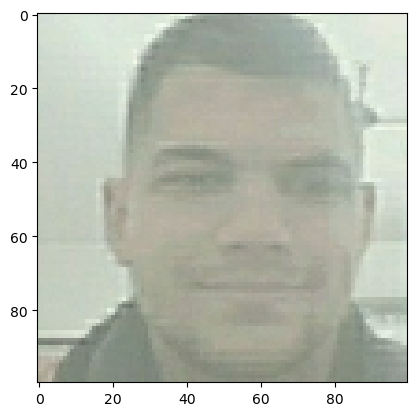

In [42]:
plt.imshow(res[1])

In [43]:
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=10000)

In [44]:
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [45]:
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [46]:
inp = Input(shape=(100,100,3), name='input_image')

In [55]:
c1 = Conv2D(64, (10,10), activation='relu')(inp)
m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
c2 = Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
c3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)

In [56]:
mod = Model(inputs=[inp], outputs=[d1], name='embedding')

In [57]:
mod.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 46, 46, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 128)       26

In [8]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [59]:
embedding = make_embedding()

In [60]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 46, 46, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 17, 17, 128)       26

In [47]:
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [48]:
l1 = L1Dist()

In [49]:
input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100,100,3))

In [64]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)
siamese_layer = L1Dist()
distances = siamese_layer(inp_embedding, val_embedding)
classifier = Dense(1, activation='sigmoid')(distances)

siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [65]:
siamese_network.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

In [13]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [67]:
siamese_model = make_siamese_model()

In [68]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

In [69]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [70]:
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

In [71]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [72]:
test_batch = train_data.as_numpy_iterator()

In [73]:
batch_1 = test_batch.next()

In [74]:
X = batch_1[:2]

In [75]:
y = batch_1[2]

In [76]:
y

array([0., 1., 0., 0., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1.],
      dtype=float32)

In [50]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
        
    # Return loss
    return loss

In [51]:
from tensorflow.keras.metrics import Precision, Recall

In [52]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Creating a metric object 
        r = Recall()
        p = Precision()
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat) 
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

In [80]:
EPOCHS = 50
train(train_data, EPOCHS)


 Epoch 1/50
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
35/35 [==============================] - 819s 23s/step
0.022305554 0.87410074 1.0

 Epoch 2/50
35/35 [==============================] - 793s 23s/step
0.08315084 0.98932385 1.0

 Epoch 3/50
35/35 [==============================] - 792s 23s/step
0.0014422977 0.98194945 1.0

 Epoch 4/50
35/35 [==============================] - 792s 23s/step
0.017375328 0.9784173 1.0

 Epoch 5/50
1/1 [==============================] - 1s 1s/step


35/35 [==============================] - 792s 23s/step
0.034683824 0.98932385 0.9964158

 Epoch 6/50
35/35 [==============================] - 795s 23s/step
0.0018283697 0.9928058 1.0

 Epoch 7/50
35/35 [==============================] - 794s 23s/step
0.04811985 0.9963768 1.0

 Epoch 8/50
35/35 [==============================] - 791s 23s/step
8.2707316e-05 1.0 1.0

 Epoch 9/50
1/1 [==============================] - 2s 2s/step


35/35 [==============================] - 791s 23s/step
0.0050109834 0.99310344 1.0

 Epoch 10/50
35/35 [==============================] - 1130s 33s/step
0.002103707 0.99638987 1.0

 Epoch 11/50
35/35 [==============================] - 1833s 52s/step
0.004352222 1.0 1.0

 Epoch 12/50
35/35 [==============================] - 1828s 52s/step
4.7489244e-05 1.0 1.0

 Epoch 13/50
35/35 [==============================] - 1841s 53s/step
0.0026875827 1.0 1.0

 Epoch 14/50
1/1 [==============================] - 8s 8s/step


35/35 [==============================] - 1051s 29s/step
0.014026636 1.0 1.0

 Epoch 15/50
35/35 [==============================] - 917s 26s/step
7.668743e-05 1.0 1.0

 Epoch 16/50
35/35 [==============================] - 823s 24s/step
5.960467e-08 1.0 1.0

 Epoch 17/50
35/35 [==============================] - 819s 23s/step
3.7252907e-09 1.0 1.0

 Epoch 18/50
1/1 [==============================] - 1s 1s/step


35/35 [==============================] - 824s 24s/step
5.420427e-06 1.0 1.0

 Epoch 19/50
35/35 [==============================] - 822s 23s/step
1.0450307e-05 1.0 1.0

 Epoch 20/50
35/35 [==============================] - 822s 24s/step
4.2767356e-06 1.0 1.0

 Epoch 21/50
35/35 [==============================] - 823s 23s/step
6.120654e-05 1.0 1.0

 Epoch 22/50
35/35 [==============================] - 820s 23s/step
0.0 1.0 1.0

 Epoch 23/50
1/1 [==============================] - 1s 1s/step


35/35 [==============================] - 822s 23s/step
0.0003035788 1.0 1.0

 Epoch 24/50
35/35 [==============================] - 823s 24s/step
1.8626463e-07 1.0 1.0

 Epoch 25/50
35/35 [==============================] - 822s 23s/step
4.9957478e-05 1.0 1.0

 Epoch 26/50
35/35 [==============================] - 823s 24s/step
2.0303155e-06 1.0 1.0

 Epoch 27/50
1/1 [==============================] - 1s 1s/step


35/35 [==============================] - 823s 24s/step
7.4505815e-09 1.0 1.0

 Epoch 28/50
35/35 [==============================] - 825s 24s/step
2.7703623e-05 1.0 1.0

 Epoch 29/50
35/35 [==============================] - 824s 24s/step
1.7689961e-05 1.0 1.0

 Epoch 30/50
35/35 [==============================] - 825s 24s/step
0.0003568712 1.0 1.0

 Epoch 31/50
1/1 [==============================] - 1s 1s/step


35/35 [==============================] - 822s 23s/step
1.3315476e-05 1.0 1.0

 Epoch 32/50
35/35 [==============================] - 821s 23s/step
1.4090617e-05 1.0 1.0

 Epoch 33/50
35/35 [==============================] - 809s 23s/step
3.352762e-08 1.0 1.0

 Epoch 34/50
35/35 [==============================] - 807s 23s/step
4.9635662e-05 1.0 1.0

 Epoch 35/50
35/35 [==============================] - 809s 23s/step
1.6801197e-06 1.0 1.0

 Epoch 36/50
1/1 [==============================] - 1s 1s/step


35/35 [==============================] - 808s 23s/step
4.5785464e-06 1.0 1.0

 Epoch 37/50
35/35 [==============================] - 809s 23s/step
0.0014969811 1.0 1.0

 Epoch 38/50
35/35 [==============================] - 806s 23s/step
9.921233e-06 1.0 1.0

 Epoch 39/50
35/35 [==============================] - 805s 23s/step
0.00023933437 1.0 1.0

 Epoch 40/50
1/1 [==============================] - 1s 1s/step


35/35 [==============================] - 807s 23s/step
1.7752263e-05 1.0 1.0

 Epoch 41/50
35/35 [==============================] - 809s 23s/step
0.00014904507 1.0 1.0

 Epoch 42/50
35/35 [==============================] - 807s 23s/step
8.285594e-06 1.0 1.0

 Epoch 43/50
35/35 [==============================] - 808s 23s/step
6.3526044e-05 1.0 1.0

 Epoch 44/50
35/35 [==============================] - 808s 23s/step
7.823111e-08 1.0 1.0

 Epoch 45/50
1/1 [==============================] - 1s 1s/step


35/35 [==============================] - 808s 23s/step
6.322123e-06 1.0 1.0

 Epoch 46/50
35/35 [==============================] - 810s 23s/step
1.2283208e-05 1.0 1.0

 Epoch 47/50
35/35 [==============================] - 806s 23s/step
0.0003646675 1.0 1.0

 Epoch 48/50
35/35 [==============================] - 807s 23s/step
5.658972e-06 1.0 1.0

 Epoch 49/50
1/1 [==============================] - 1s 1s/step


35/35 [==============================] - 807s 23s/step
9.614914e-05 1.0 1.0

 Epoch 50/50
35/35 [==============================] - 808s 23s/step
1.2521509e-05 1.0 1.0


In [57]:
from tensorflow.keras.metrics import Precision, Recall

In [58]:
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [59]:
test_var = test_data.as_numpy_iterator().next()
len(test_var[0])

16

In [60]:
y_hat = siamese_model.predict([test_input, test_val])
y_hat

NameError: name 'siamese_model' is not defined

In [61]:
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

NameError: name 'y_hat' is not defined

In [103]:
y_true

array([0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 0., 0., 0., 1.],
      dtype=float32)

In [62]:
# Creating a metric object 
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

NameError: name 'y_hat' is not defined

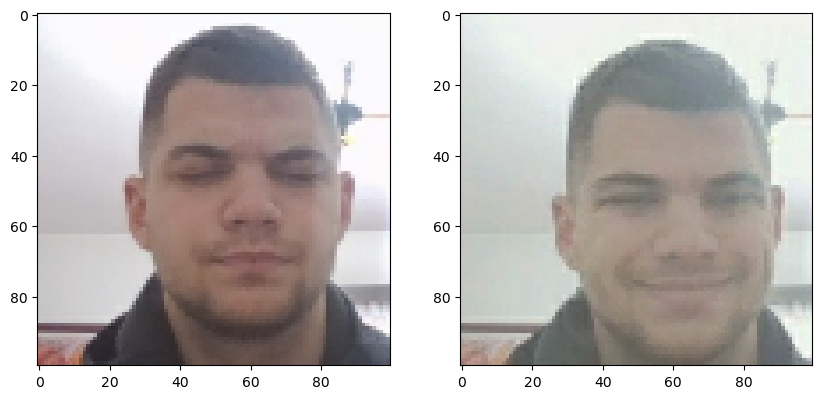

In [106]:
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[2])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[2])

# Renders cleanly
plt.show()

In [107]:
siamese_model.save('siamesemodel.h5')

In [63]:
L1Dist

__main__.L1Dist

In [64]:
model = tf.keras.models.load_model('siamesemodel.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [65]:
model.predict([test_input, test_val])

1/1 [==============================] - 2s 2s/step


array([[2.9664708e-09],
       [1.7404574e-07],
       [1.0000000e+00],
       [4.0173957e-09],
       [5.9929300e-07],
       [1.3097483e-06],
       [5.3209431e-10],
       [1.0000000e+00],
       [5.0640709e-09],
       [4.1855515e-08],
       [1.0000000e+00],
       [1.0000000e+00],
       [7.8753720e-10],
       [2.8767162e-09],
       [9.3237080e-09],
       [8.4162831e-01]], dtype=float32)

In [66]:
# View model summary
model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

In [12]:
for image in os.listdir(os.path.join('application_data', 'verification_image')):
    validation_img = os.path.join('application_data', 'input_image', image)
    print(validation_img)

application_data\input_image\000b04b8-e51b-11ed-b97d-387a0e15f8b4.jpg
application_data\input_image\000b77e6-e51b-11ed-9414-387a0e15f8b4.jpg
application_data\input_image\000bc649-e51b-11ed-85c9-387a0e15f8b4.jpg
application_data\input_image\000c141e-e51b-11ed-ad6b-387a0e15f8b4.jpg
application_data\input_image\000c8932-e51b-11ed-bb98-387a0e15f8b4.jpg
application_data\input_image\000d0092-e51b-11ed-a1b2-387a0e15f8b4.jpg
application_data\input_image\000d4e73-e51b-11ed-b705-387a0e15f8b4.jpg
application_data\input_image\000d9b70-e51b-11ed-9ac1-387a0e15f8b4.jpg
application_data\input_image\000e121b-e51b-11ed-ae25-387a0e15f8b4.jpg
application_data\input_image\00a11693-e51b-11ed-8e71-387a0e15f8b4.jpg
application_data\input_image\00a164c5-e51b-11ed-8cfe-387a0e15f8b4.jpg
application_data\input_image\00a1d9f5-e51b-11ed-9ea2-387a0e15f8b4.jpg
application_data\input_image\00a22814-e51b-11ed-99b0-387a0e15f8b4.jpg
application_data\input_image\00a24f0b-e51b-11ed-aabf-387a0e15f8b4.jpg
application_data\inp

In [14]:
os.listdir(os.path.join('application_data', 'verification_image'))

['000b04b8-e51b-11ed-b97d-387a0e15f8b4.jpg',
 '000b77e6-e51b-11ed-9414-387a0e15f8b4.jpg',
 '000bc649-e51b-11ed-85c9-387a0e15f8b4.jpg',
 '000c141e-e51b-11ed-ad6b-387a0e15f8b4.jpg',
 '000c8932-e51b-11ed-bb98-387a0e15f8b4.jpg',
 '000d0092-e51b-11ed-a1b2-387a0e15f8b4.jpg',
 '000d4e73-e51b-11ed-b705-387a0e15f8b4.jpg',
 '000d9b70-e51b-11ed-9ac1-387a0e15f8b4.jpg',
 '000e121b-e51b-11ed-ae25-387a0e15f8b4.jpg',
 '00a11693-e51b-11ed-8e71-387a0e15f8b4.jpg',
 '00a164c5-e51b-11ed-8cfe-387a0e15f8b4.jpg',
 '00a1d9f5-e51b-11ed-9ea2-387a0e15f8b4.jpg',
 '00a22814-e51b-11ed-99b0-387a0e15f8b4.jpg',
 '00a24f0b-e51b-11ed-aabf-387a0e15f8b4.jpg',
 '00a2c4e2-e51b-11ed-ab69-387a0e15f8b4.jpg',
 '00a31376-e51b-11ed-8704-387a0e15f8b4.jpg',
 '00a36192-e51b-11ed-947e-387a0e15f8b4.jpg',
 '00a3afc0-e51b-11ed-9e1b-387a0e15f8b4.jpg',
 '00b381e6-e51b-11ed-83f2-387a0e15f8b4.jpg',
 '00b3d509-e51b-11ed-871c-387a0e15f8b4.jpg',
 '00b449a9-e51b-11ed-8a1d-387a0e15f8b4.jpg',
 '00b49860-e51b-11ed-9786-387a0e15f8b4.jpg',
 '00b4e615

In [15]:
os.path.join('application_data', 'input_image', 'input_image.jpg')

'application_data\\input_image\\input_image.jpg'

In [89]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_image')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_image', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_image'))) 
    verified =  verification > verification_threshold

    return results, verified
    


In [90]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder 
        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(model, 0.9, 0.7)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 149ms/step
True
1/1 [==============================] - 0s 148ms/step
False
